In [1]:
from sympy.combinatorics import Permutation, PermutationGroup
import numpy as np
import math
import sympy
import sympy.functions.combinatorial.numbers as math_num
from scipy.stats import chisquare
from scipy.stats import chi2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import time
from tqdm import tqdm
import pickle 

In [2]:
def conv(x, y, r=5): # x - O, y - E
    m = 0
    s = 0
    for i in range(len(x)):
        m += i*x[i]
        s += x[i]
    m = int(m/s) # the center of distr
    # print(m)
    left_x = [0 for k in range(m+1)] # should be croped
    left_y = [0 for k in range(m+1)] #
    # to the right
    i = 0
    k = 0
    while i <= m:
        s1 = x[i]
        s2 = y[i]
        if x[i] < r:
            while s1 < r:
                i += 1
                s1 += x[i]
                s2 += y[i]
        left_x[k] = s1
        left_y[k] = s2
        i += 1
        k += 1
    # to the left
    right_x = [0 for k in range(len(x) - m)]
    right_y = [0 for k in range(len(x) - m)]
    k = len(x) - m - 1
    i = len(x) - 1
    while i > m:
        s1 = x[i]
        s2 = y[i]
        if x[i] < r:
            while s1 < r:
                i -= 1
                s1 += x[i]
                s2 += y[i]
        right_x[k] = s1
        right_y[k] = s2
        i -= 1
        k -= 1
    
    while left_x[-1] == 0:
        left_x.pop()
        left_y.pop()
        
    while right_x[0] == 0:
        del right_x[0]
        del right_y[0]
    
    return (left_x + right_x, left_y + right_y)

In [8]:
def chi(O, E, print_mode=False):
    if print_mode:
        print(O)
        print(E)
    O,E = conv(O, E)
    if print_mode:
        print(O)
        print(E)
    r = 0
    for i in range(len(O)):
        r += (O[i] - E[i])**2/E[i]
    return (r, len(O))

## Permutation

In [17]:
n = 10  # длина подстановки нужно выявить зависимость n ~ N, с сохранением удовлетворения критериям оценки
N = 2**10 # размер выборки подстановок

num_of_cycles = [0 for k in range(n+1)]
num_of_fixed_points = [0 for k in range(n+1)]
num_of_shortest_cycle = [0 for k in range(n+1)]
num_of_inversions = [0 for k in range(int(n*(n-1)/2) + 1)]
# num_of_orders = [0 for k in range(int(sympy.exp(n/sympy.exp(1))) + 1)]
# num_of_orders = {}

for i in tqdm(range(N)):
    a = Permutation(np.random.permutation(n))
    #cycle_num = a.cycles
    #num_of_cycles[a.cycles] += 1
    #if 1 in a.cycle_structure.keys():
    #    num_of_fixed_points[a.cycle_structure[1]]  += 1
    #else:
    #    num_of_fixed_points[0] += 1
    num_of_shortest_cycle[min(a.cycle_structure.keys())] += 1 
#    order = 1
#    for x in list(a.cycle_structure.keys()):
#        order = np.lcm(order, x)
#    if order in num_of_orders:
 #       num_of_orders[order] += 1
 #   else:
 #       num_of_orders[order] = 1
    # num_of_inversions[a.inversions()] += 1
    
    
    
#print(num_of_cycles)
#print(num_of_fixed_points)
print(num_of_shortest_cycle)
#print(num_of_orders)
# print(num_of_inversions)

#print(a)
#print(a.list())
#print(a.inversions())
#print(a.is_even)


100%|█████████████████████████████████████| 1024/1024 [00:00<00:00, 2946.91it/s]

[0, 673, 134, 59, 36, 16, 0, 0, 0, 0, 106]


## Comparison of statistical distributions

In [263]:
# Кратчайший цикл имеет длину k

def expindex(x, M):
    res = x
    for i in range(2, M + 1):
        res += (x**i) / i
    return -res

def nthcoeff(f, x, n):
    res = sympy.diff(f, x, n)
    return res.subs(x, 0) / math.factorial(n)

def get_polynom_for_cycle_length(M, n): 
    x = sympy.Symbol('x')
    f = 1 - sympy.exp(-x) if  M == 0 else sympy.exp(expindex(x, M)) - sympy.exp(expindex(x, M + 1))
    return nthcoeff(f / (1 - x), x, n)

def gen_prob_of_shortest_cycles(n):
    t = time.perf_counter()
    short_cycle_length_exp = [0] * n
    for i in tqdm(range(math.floor(n / 2) + 1)):
        short_cycle_length_exp[i] = get_polynom_for_cycle_length(i, n) 
    short_cycle_length_exp[n-1] = get_polynom_for_cycle_length(n-1, n)
    exp = np.array(np.array([float(i) for i in short_cycle_length_exp]))
    return exp

def gen_prob_of_shortest_cycles2(n):
    exp = [0] * (n+1)
    for i in range(1, math.floor(n / 2)):
        exp[i+1] = math.exp(-sympy.harmonic(i)) - math.exp(-sympy.harmonic(i+1))
    exp[1] = 1 - math.exp(-1)
    exp[n] = 1 / n
    return exp

# inversion 

def gen_num_of_inversions(n):
    i = 1
    result = [1]
    while i < n:
        prev = result[:]
        result = [0] * int(1 + ((i + 1) * 0.5) * (i))
        m = [1] * (i + 1)
        for j in range(len(m)):
            for k in range(len(prev)):
                result[k+j] += m[j] * prev[k]
        i = i + 1
    return result

# inversion N*K - dynamic programming, recursive

def mahonian_triangle(n): # to n inclusive
    try:
        with open('E_num_of_inversions.pkl', 'rb') as f:
            E_num_of_inversions = pickle.load(f)
    except:
        E_num_of_inversions = {1: [1], 2: [1, 1]}
    
    # print('dict len', len(E_num_of_inversions.keys()))

    for i in tqdm(range(len(E_num_of_inversions.keys()), n + 1)):
        k = math.floor(((i+1)*i/2)/2) + 1
        arr1 = E_num_of_inversions[i]
        arr = [0 for c in range(0, k)]
        for c in range(0, k):
            v = 0
            while (c - v >= 0) & (v <= i): 
                arr[c] += arr1[c-v]
                v += 1
        E_num_of_inversions[i+1] = arr[:len(arr)- int(((int(i+1)*i/2) + 1)%2)] + arr[::-1]
        with open('E_num_of_inversions.pkl', 'wb') as f:
            pickle.dump(E_num_of_inversions, f)
        
    return E_num_of_inversions

In [264]:
mahonian_triangle(2**10)
print('done')

 25%|██████████▎                              | 216/858 [09:18<27:40,  2.59s/it]


KeyboardInterrupt: 

In [259]:
try:
    with open('E_prob_of_fixed_points.pkl', 'rb') as f:
        E_prob_of_fixed_points = pickle.load(f)
except:
    E_prob_of_fixed_points = {}

try:
    with open('E_prob_of_cycles.pkl', 'rb') as f:
        E_prob_of_cycles = pickle.load(f)
except:
    E_prob_of_cycles = {}
    
try:    
    with open('E_prob_of_shortest_cycle.pkl', 'rb') as f:
        E_prob_of_shortest_cycle = pickle.load(f)
except:
    E_prob_of_shortest_cycle = {}

try:
    with open('E_prob_of_inversions.pkl', 'rb') as f:
        E_prob_of_inversions = pickle.load(f)
except:
    E_prob_of_inversions = {}

# Неподвижные точки
def FP_criteria(num_of_fixed_points, n, N, alpha=0.05, print_mode=False):
    if n not in E_prob_of_fixed_points:
        E_prob_of_fixed_points[n] = [((1 / math.factorial(k)) * (sympy.subfactorial(n - k) / math.factorial(n - k))) for k in range(n+1)]
        with open('E_prob_of_fixed_points.pkl', 'wb') as f:
            pickle.dump(E_prob_of_fixed_points, f)
    E_num_of_fixed_points = [ x*N  for x in E_prob_of_fixed_points[n]]
    
    (num_of_fixed_points_stat, points_array_len) = chi(num_of_fixed_points, E_num_of_fixed_points, print_mode)

    points_quantile = chi2.ppf(1-0.05, df=points_array_len-1)
    p_value = chi2.sf(float(num_of_fixed_points_stat), int(points_array_len-1))
    if print_mode:
        print("Квантиль степени " + str(points_array_len - 1) + " = " + str(points_quantile))
        print("Статистика для k неподвижных точек = " + str(num_of_fixed_points_stat))
        print("p-value = " + str(p_value))
    else:
        return (num_of_fixed_points_stat, points_quantile, p_value)
    
# Длины циклов
def CL_criteria(num_of_cycles, n, N, alpha=0.05, print_mode=False):
    if n not in E_prob_of_cycles:
        E_prob_of_cycles[n] = [((1 / math.factorial(n)) * math_num.stirling(n, k, kind=1)) for k in range(len(num_of_cycles))]
        with open('E_prob_of_cycles.pkl', 'wb') as f:
            pickle.dump(E_prob_of_cycles, f)
    E_num_of_cycles = [ x*N  for x in E_prob_of_cycles[n]]
    (num_of_cycle_stat, cycle_array_len) = chi(num_of_cycles, E_num_of_cycles, print_mode)

    cycle_quantile = chi2.ppf(1-alpha, df=cycle_array_len-1)
    p_value = chi2.sf(float(num_of_cycle_stat), int(cycle_array_len-1))

    if print_mode:
        print("Квантиль степени " + str(cycle_array_len - 1) + " = " + str(cycle_quantile))
        print("Статистика для ровно k циклов = " + str(num_of_cycle_stat))
        print("p-value = " + str(p_value))
    else:
        return (num_of_cycle_stat, cycle_quantile, p_value)

# Кратчайший цикл имеет длину k ??????? n -> inf -> doesnt work
def SC_criteria(num_shortest_cycle,  n, N, alpha=0.05, print_mode=False):
    if n not in E_prob_of_shortest_cycle:
        E_prob_of_shortest_cycle[n] = gen_prob_of_shortest_cycles2(n) # without 2 -> its coeff method
        with open('E_prob_of_shortest_cycle.pkl', 'wb') as f:
            pickle.dump(E_prob_of_shortest_cycle, f)
    E_num_of_shortest_cycle = [ x*N  for x in E_prob_of_shortest_cycle[n]]

    #num_shortest_cycle = gen_prob_of_shortest_cycles2(n)
    #num_shortest_cycle = [ x*N  for x in num_shortest_cycle]

    (shortest_cycle_stat, shortest_cycle_array_len) = chi(num_shortest_cycle, E_num_of_shortest_cycle, print_mode)

    shortest_cycle_quantile = chi2.ppf(1-alpha, df=shortest_cycle_array_len-1)
    p_value = chi2.sf(float(shortest_cycle_stat), int(shortest_cycle_array_len-1))
    
    if print_mode:
        print("Квантиль степени " + str(shortest_cycle_array_len - 1) + " = " + str(shortest_cycle_quantile))
        print("Статистика для минимального цикла длины k = " + str(shortest_cycle_stat))
        print("p-value = " + str(p_value))
    else:
        return (shortest_cycle_stat, shortest_cycle_quantile, p_value)

# Количество инверсий N*K - dynamic programming mahonian row
def Inv_criteria(num_of_inversions, n, N, alpha=0.05, print_mode=False):
    if n not in E_prob_of_inversions:
        E_prob_of_inversions[n] = [i/math.factorial(n) for i in gen_num_of_inversions(n)]
        with open('E_prob_of_inversions.pkl', 'wb') as f:
            pickle.dump(E_prob_of_inversions, f)
    E_num_of_inversions = [i * N for i in E_prob_of_inversions[n]]
    
    (inversions_stat, inversions_array_len) = chi(num_of_inversions, E_num_of_inversions, print_mode)

    inversions_quantile = chi2.ppf(1-alpha, df=inversions_array_len-1)
    p_value = chi2.sf(float(inversions_stat), int(inversions_array_len-1))
    
    if print_mode:
        print("Квантиль степени " + str(inversions_array_len - 1) + " = " + str(inversions_quantile))
        print("Статистика для минимального цикла длины k = " + str(inversions_stat))
        print("p-value = " + str(p_value))
    else:
        return (inversions_stat, inversions_quantile, p_value)

In [20]:
# FP_criteria(num_of_fixed_points, n, N, print_mode=True)
# CL_criteria(num_of_cycles, n, N, print_mode=True)
SC_criteria(num_shortest_cycle, n, N, print_mode=True)
# Inv_criteria(num_of_inversions, n, N, print_mode=True)

[0, 651, 137, 60, 45, 21, 0, 0, 0, 0, 110]
[0, 647.291452240443, 148.22326376756482, 64.76842400638557, 36.21404122682465, 23.112339936838936, 0, 0, 0, 0, 102.4]
[651, 137, 60, 45, 21, 110]
[647.291452240443, 148.22326376756482, 64.76842400638557, 36.21404122682465, 23.112339936838936, 102.4]
Квантиль степени 5 = 11.070497693516351
Статистика для минимального цикла длины k = 4.110819016808848
p-value = 0.5335736714071853


In [ ]:
if n not in E_prob_of_shortest_cycle:
        E_prob_of_shortest_cycle[n] = gen_prob_of_shortest_cycles2(n) # without 2 -> its coeff method
        with open('E_prob_of_shortest_cycle.pkl', 'wb') as f:
            pickle.dump(E_prob_of_shortest_cycle, f)
    E_num_of_shortest_cycle = [ x*N  for x in E_prob_of_shortest_cycle[n]]

## Show distributions

/usr/lib/python3/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


         D1             D2  x
0  166185.0  165706.611774  0
1   37691.0   37945.155524  1
2   16085.0   16580.716546  2
3   10971.0    9270.794554  3
4    5187.0    5916.759024  4
5   26025.0   26214.400000  5


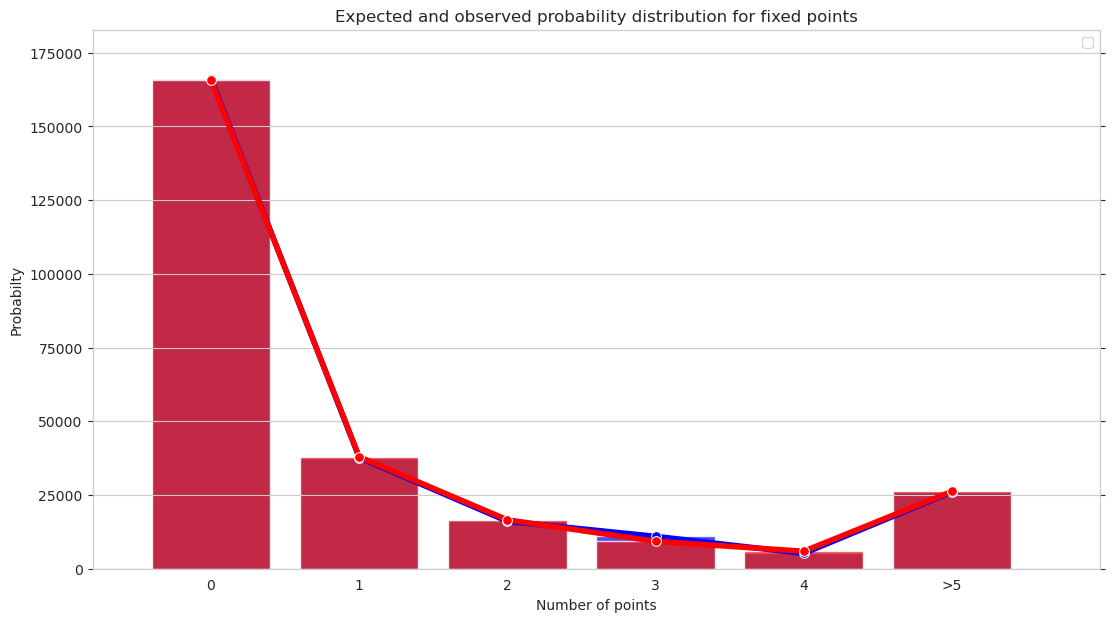

In [14]:
# x,y - two arrays with distribution, r - first x label
def compare_two_distr_graph(x, y, r=0):
    df_to_show = pd.DataFrame(columns = ['D1', 'D2'])
    df_to_show['D1'], df_to_show['D2'] = conv(x, y, 0.01)
    df_to_show['D1'], df_to_show['D2'] = df_to_show['D1'].astype(float), df_to_show['D2'].astype(float)
    df_to_show['x'] = [k for k in range(0, len(df_to_show))]
    print(df_to_show)
    xticklabels= [k for k in range(r, len(df_to_show)+r)]
    xticklabels[len(df_to_show)-1] = '>' + str(len(df_to_show)+r-1)
    width = 0.8
    matplotlib.rc_file_defaults()
    ax = sns.set_style(style="whitegrid", rc=None)
    fig, ax = plt.subplots(figsize=(13,7))
    ax_twin = ax.twinx()
    sns.barplot(data = df_to_show, x='x', y='D1', alpha=0.8, ax=ax, color = 'blue', width=width)
    sns.barplot(data = df_to_show, x='x', y='D2', alpha=0.8, ax=ax, color = 'red', width=width).set(xlabel = "Number of points",ylabel='Probabilty', xticklabels=xticklabels)
        
    sns.lineplot(data = df_to_show, x='x', y='D1', marker='o', err_style='bars', color = 'blue', ax=ax_twin, sort = False, linewidth = 4, markersize=7).set(ylabel='Probabilty')
    sns.lineplot(data = df_to_show, x='x', y='D2', marker='o', err_style='bars', color = 'red', ax=ax_twin, sort = False, linewidth = 4, markersize=7).set(title='Expected and observed probability distribution for fixed points', yticklabels=[], ylabel=None)
     
    max_x = len(df_to_show)
    max_y = max(max(df_to_show['D1']), max(df_to_show['D2']))*1.1
    ax.set_xlim([-width, max_x])
    ax.set_ylim([0, max_y])
    ax_twin.set_xlim([-width, max_x])
    ax_twin.set_ylim([0, max_y])
    ax.legend() ## add legend

if n not in E_prob_of_shortest_cycle:
        E_prob_of_shortest_cycle[n] = gen_prob_of_shortest_cycles2(n) # without 2 -> its coeff method
        with open('E_prob_of_shortest_cycle.pkl', 'wb') as f:
            pickle.dump(E_prob_of_shortest_cycle, f)
E_num_of_shortest_cycle = [ x*N  for x in E_prob_of_shortest_cycle[n]]
compare_two_distr_graph(num_of_shortest_cycle, E_num_of_shortest_cycle, 0)



## Correlation table

In [62]:
def count_records(permutation: Permutation): 
    maximum = -1
    records = 0 
    for index, elem in enumerate(permutation.list()): 
         if elem > maximum: 
            records += 1
            maximum = elem    
    return records

In [63]:
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())

def calculate_avg_length(a):
    r = k = 0
    for i in a:
        r += k*i
        k += 1
    return r

In [70]:
# correlation table

corr_df = pd.DataFrame(columns=['n','N','FP & SC', 'FP & Rec', 'FP & NoC', 'FP & Ord', 'FP & Inv', 'FP & Evn',
                                'SC & NoC', 'SC & Rec', 'SC & Ord', 'SC & Inv', 'SC & Evn', 'Rec & NoC',
                                'Rec & Ord', 'Rec & Inv', 'Rec & Evn', 'NoC & Ord', 'NoC & Inv', 'NoC & Evn',
                                'Ord & Inv', 'Ord & Evn', 'Inv & Evn'])

# длина подстановки n
# длина выборки N
n_N_values = [(10, 150000), 
              (25, 150000), 
              (50, 150000), 
              (100, 150000),
              (200, 150000),
              (500, 150000),
              (1000, 150000),
             ]

n_N_values2 = [(2**9, 1000), (2**9, 5000), (2**9, 12000), 
              (2**10, 1000), (2**10, 5000), (2**10, 12000),
              (2**11, 1000), (2**11, 5000), (2**11, 12000),
             ]

t1 = time.perf_counter()

for p in n_N_values[4:5]:
    
    n, N = p
    
    # 'Fixed points','Shortest cycle','Records', 'Number of cycles', 'Order', 'Inversions', 'Even'
    df = pd.DataFrame(columns=['FP','SC','Rec', 'NoC', 'Ord', 'Inv', 'Evn'])

    num_of_cycles = 0
    num_of_fixed_points = 0
    length_of_shortes_cycle = 0
    order = 1
    even = 0
    inversions = 0
    
    for i in tqdm(range(N)):
        a = Permutation(np.random.permutation(n))
        num_of_cycles = a.cycles
        if 1 in a.cycle_structure.keys():
            num_of_fixed_points = a.cycle_structure[1]
        else:
            num_of_fixed_points = 0
        length_of_shortes_cycle = min(a.cycle_structure.keys())
        num_of_records = count_records(a)
        order = 1
        for x in list(a.cycle_structure.keys()):
            order = np.lcm(order, x)
        even = a.is_even
        inversions = a.inversions()
        df.loc[len(df)] = [num_of_fixed_points, length_of_shortes_cycle, num_of_records, num_of_cycles, order, inversions, even]        
            
    print("n="+ str(n), "N=" + str(N), " - Done," + " Time: " + str(round(time.perf_counter() - t1, 1)))
    df = df.astype({"Evn": int})
    #for col in df.columns:
    #    df[col] = min_max_scaling(df[col])
    cm = df.corr()
    corr_df.loc[len(corr_df)] = [n, N, cm['FP']['SC'], cm['FP']['Rec'], cm['FP']['NoC'], cm['FP']['Ord'], cm['FP']['Inv'],
                                 cm['FP']['Evn'], cm['SC']['Rec'], cm['SC']['NoC'], cm['SC']['Ord'], cm['SC']['Inv'], cm['SC']['Evn'],
                                 cm['Rec']['NoC'], cm['Rec']['Ord'], cm['Rec']['Inv'], cm['Rec']['Evn'], cm['NoC']['Ord'],
                                 cm['NoC']['Inv'], cm['NoC']['Evn'], cm['Ord']['Inv'], cm['Ord']['Evn'], cm['Inv']['Evn'],
                                ]


corr_df = corr_df.round(3)
corr_df = corr_df.astype({"n": int, "N": int})
# df.to_csv("./df.csv", index=None)  
# df.to_csv("./df.csv", index=None, mode='a', header=None)  
# corr_df.to_csv("./corr.csv", index=None)  
corr_df.to_csv("./corr.csv", index=None, mode='a', header=None)  

100%|███████████████████████████████████| 150000/150000 [25:27<00:00, 98.23it/s]

n=200 N=150000  - Done, Time: 1527.1


In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True)

In [ ]:
print(df)

In [73]:
n_N_values = [(2**9, 1000), (2**9, 5000), (2**9, 12000), 
              (2**10, 1000), (2**10, 5000), (2**10, 12000),
              (2**11, 1000), (2**11, 5000), (2**11, 12000),
             ]

## n ~ N relationship chi-square

In [119]:
n_N_values = [ (25, 2**10), (25, 2**12), (25, 2**14), (25, 2**16), 
              (50, 2**10), (50, 2**12), (50, 2**14), (50, 2**16), 
              (100, 2**10), (100, 2**12), (100, 2**14), (100, 2**16), (100, 2**18),
              (200, 2**10), (200, 2**14), (200, 2**16), (200, 2**18),
             ]

In [77]:
# s - statistic, q - quantile, p - p-value
j_max = 10

for p in n_N_values:
    n, N = p
    df = pd.DataFrame(columns=['n', 'N', 'aFP-s', 'aFP-q', 'aFP-p', 'aCL-s', 'aCL-q', 'aCL-p', 'aSC-s', 'aSC-q', 'aSC-p', 'aInv-s', 'aInv-q', 'aInv-p', 'FP s<q', 'CL s<q', 'SC s<q', 'Inv s<q'])
    fp = [np.zeros(j_max), np.zeros(j_max), np.zeros(j_max)] # 0 - stat, 1 - quantile, 2 - p-value
    cl = [np.zeros(j_max), np.zeros(j_max), np.zeros(j_max)]
    sc = [np.zeros(j_max), np.zeros(j_max), np.zeros(j_max)]
    inv = [np.zeros(j_max), np.zeros(j_max), np.zeros(j_max)]
    f = np.array([0, 0, 0, 0])
    for j in range(j_max):
        num_of_cycles = [0 for k in range(n+1)]
        num_of_fixed_points = [0 for k in range(n+1)]
        num_shortest_cycle = [0 for k in range(n+1)]
        num_of_inversions = [0 for k in range(int(n*(n-1)/2) + 1)]
                    
        a = Permutation(np.random.permutation(n))

        for i in tqdm(range(N)):
            a = Permutation(np.random.permutation(n))
            cycle_num = a.cycles
            num_of_cycles[a.cycles] += 1
            if 1 in a.cycle_structure.keys():
                num_of_fixed_points[a.cycle_structure[1]]  += 1
            else:
                num_of_fixed_points[0] += 1
            num_shortest_cycle[min(a.cycle_structure.keys())] += 1     
            num_of_inversions[a.inversions()] += 1
                    
        print(1)
        fp[0][j], fp[1][j], fp[2][j] = FP_criteria(num_of_fixed_points, n, N)
        print(2)
        cl[0][j], cl[1][j], cl[2][j] = CL_criteria(num_of_cycles, n, N)
        print(3)
        sc[0][j], sc[1][j], sc[2][j] = SC_criteria(num_shortest_cycle, n, N)
        print(4)
        inv[0][j], inv[1][j], inv[2][j] = Inv_criteria(num_of_inversions, n, N)
        print(5)
            
        f[0] += int(fp[0][j] < fp[1][j])
        f[1] += int(cl[0][j] < cl[1][j])
        f[2] += int(sc[0][j] < sc[1][j])
        f[3] += int(inv[0][j] < inv[1][j])
            
        #if (fp[0].mean() < fp[1].mean()) & (cl[0].mean() < cl[1].mean()) & (sc[0].mean() < sc[1].mean()) & (inv[0].mean() < inv[1].mean()):  
        #    f = False
        
    df.loc[len(df)] = [n, N, fp[0].mean(), fp[1].mean(), fp[2].mean(), cl[0].mean(), cl[1].mean(), cl[2].mean(),
                             sc[0].mean(), sc[1].mean(), sc[2].mean(), inv[0].mean(), inv[1].mean(), inv[2].mean(),
                             f[0],  f[1],  f[2],  f[3]]
    print('n =', n, 'N =', N, 'Done = ' + str(f))    
    df = df.round(3)
    df = df.astype({"n": int, "N": int, 'FP s<q':int, 'CL s<q':int, 'SC s<q':int, 'Inv s<q':int})
    df.to_csv("./df_n_N.csv", index=None, mode='a', header=None)  

100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.19it/s]


1
2
3
4


KeyboardInterrupt: 

In [ ]:
# x,y - two arrays with distribution, r - first x label
def corr_table(x, y, r=0):
    df_to_show = pd.DataFrame(columns = ['D1', 'D2'])
    df_to_show['D1'], df_to_show['D2'] = conv(x, y, 0.01)
    df_to_show['D1'], df_to_show['D2'] = df_to_show['D1'].astype(float), df_to_show['D2'].astype(float)
    df_to_show['x'] = [k for k in range(0, len(df_to_show))]
    print(df_to_show)
    xticklabels= [k for k in range(r, len(df_to_show)+r)]
    xticklabels[len(df_to_show)-1] = '>' + str(len(df_to_show)+r-1)
    width = 0.8
    matplotlib.rc_file_defaults()
    ax = sns.set_style(style="whitegrid", rc=None)
    fig, ax = plt.subplots(figsize=(13,7))
    # ax_twin = ax.twinx()
    # sns.barplot(data = df_to_show, x='x', y='D1', alpha=0.8, ax=ax, color = 'blue', width=width)
    # sns.barplot(data = df_to_show, x='x', y='D2', alpha=0.8, ax=ax, color = 'red', width=width).set(xlabel = "Number of points",ylabel='Probabilty', xticklabels=xticklabels)
        
    sns.lineplot(data = df_to_show, x='x', y='D1', marker='o', err_style='bars', color = 'blue', ax=ax_twin, sort = False, linewidth = 4, markersize=7).set(ylabel='Probabilty')
    sns.lineplot(data = df_to_show, x='x', y='D2', marker='o', err_style='bars', color = 'red', ax=ax_twin, sort = False, linewidth = 4, markersize=7).set(title='Expected and observed probability distribution for fixed points', yticklabels=[], ylabel=None)
     
    max_x = len(df_to_show)
    max_y = max(max(df_to_show['D1']), max(df_to_show['D2']))*1.1
    ax.set_xlim([-width, max_x])
    ax.set_ylim([0, max_y])
    ax_twin.set_xlim([-width, max_x])
    ax_twin.set_ylim([0, max_y])
    ax.legend() ## add legend

In [67]:
corr_df = pd.read_csv("./corr.csv") 
corr_df

,n,N,FP & SC,FP & Rec,FP & NoC,FP & Ord,FP & Inv,FP & Evn,SC & Noc,SC & Rec,...,Rec & NoC,Rec & Ord,Rec & Inv,Rec & Evn,Noc & Ord,Noc & Inv,Noc & Evn,Ord & Inv,Ord & Evn,Inv & Evn
0,10,1024,-0.516,0.125,0.775,-0.298,-0.297,0.008,-0.030,-0.652,...,0.118,-0.055,-0.541,-0.011,-0.179,-0.202,0.032,0.042,-0.094,-0.018
1,10,4096,-0.512,0.104,0.766,-0.294,-0.344,-0.013,-0.022,-0.647,...,0.076,-0.050,-0.541,0.020,-0.162,-0.255,0.018,0.103,-0.146,0.001
2,10,16384,-0.506,0.109,0.761,-0.289,-0.323,-0.006,-0.043,-0.639,...,0.086,-0.025,-0.533,0.006,-0.164,-0.240,0.002,0.096,-0.139,-0.003
3,10,65536,-0.509,0.115,0.766,-0.292,-0.325,-0.001,-0.045,-0.649,...,0.081,-0.038,-0.541,0.000,-0.162,-0.237,0.010,0.092,-0.136,-0.001
4,10,262144,-0.508,0.111,0.766,-0.294,-0.330,-0.001,-0.043,-0.647,...,0.081,-0.032,-0.540,0.000,-0.163,-0.244,0.007,0.095,-0.138,0.003
5,25,1024,-0.372,0.018,0.667,-0.097,-0.189,-0.018,-0.012,-0.526,...,-0.005,-0.010,-0.364,0.004,0.149,-0.118,0.004,0.000,-0.100,-0.023
6,25,4096,-0.379,0.033,0.647,-0.093,-0.213,-0.012,-0.001,-0.514,...,0.023,-0.011,-0.337,0.004,0.133,-0.132,0.008,0.020,-0.102,-0.005
7,25,16384,-0.383,0.028,0.643,-0.092,-0.199,0.017,-0.015,-0.521,...,0.017,-0.000,-0.329,0.005,0.141,-0.119,0.007,0.018,-0.127,-0.011
8,25,65536,-0.384,0.036,0.649,-0.082,-0.212,0.002,-0.016,-0.524,...,0.029,0.003,-0.336,-0.005,0.152,-0.139,-0.004,0.010,-0.134,0.004
9,25,262144,-0.382,0.028,0.647,-0.088,-0.204,0.001,-0.011,-0.520,...,0.020,0.001,-0.334,-0.001,0.149,-0.130,-0.004,0.016,-0.126,0.001


In [68]:
corr_df = corr_df.melt(id_vars=['n', 'N'], var_name='Values name', value_name='Corr')

In [69]:
import plotly.express as px

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

fig = px.scatter_3d(corr_df, x='n', y='N', z='Corr', color='Values name', title='Correlation between 7 main characteristics')

fig.show()


## Expirement

In [269]:
import numpy as np
import operator
import sys
import random
import functools
import bitarray
from bitarray.util import int2ba
from tqdm import tqdm



def gen_permutation(f):
    res = np.empty(N)
    for el in range(N):
        res[el] = f(el)
    return res


def gen_quasigroup(f, phi, psy, pls):
    def g(x, y):
        return f(pls(phi(x), psy(y)))
    return g


def bijection(permutation):
    def f(x):
        return permutation[x]
    return f


def random_bijection(n):
    perm = np.random.permutation(n)
    return bijection(perm)


def left_shift(f, el):
    def g(x):
        return f(el, x)
    return g


def right_shift(f, el):
    def g(x):
        return f(x, el)
    return g


def multiple_left_shifts(*args, f):
    def g(x):
        res = x
        for el in args:
            res = f(el, x)
    return g


def multiple_right_shifts(*args, f):
    def g(x):
        res = x
        for el in args:
            res = f(x, el)
    return g


def pi():
    X = bitarray.bitarray([random.choice([True, False]) for _ in range(4)])
    def f(x, y):
        return X[2*x + y]
    return f


def good_pi():
    pi_funcs = [
                lambda x, y: x and y,
                lambda x, y: (x and y) ^ 1,
                lambda x, y: (x and y) ^ x,
                lambda x, y: (x and y) ^ y,
                lambda x, y: (x and y) ^ x ^ 1,
                lambda x, y: (x and y) ^ y ^ 1,
                lambda x, y: x ^ y,
                lambda x, y: x ^ y ^ 1,
                lambda x, y: (x and y) ^ x ^ y
            ]
    return pi_funcs[np.random.randint(0, 9)]


def quad_functions(args, i):
    ln = len(args)
    res = functools.reduce(lambda x, y: x != y, args[:i], False)
    res = functools.reduce(lambda x, y: x != y, [args[j] and args[k] for j in range(ln) for k in range(j) if (k != i and j != i)], res)
    return res


def triangle_functions(args, i):
    return random_bool_function(i - 1)(args[:i])


def random_bool_function(n: int): 
    N = 1 << n
    X = int2ba(random.randint(0, N-1), length = N)

    def f(args: bitarray.bitarray): 
        return X[sum([(1<<i) * el for i, el in enumerate(args)])]
    return f


def quasigroup_operation_quad(is_good_pi: bool = False):
    if not is_good_pi:
        rnd_fs = [good_pi() for _ in range(n)]
    else: 
        rnd_fs = [pi() for _ in range(n)]

    def f(x, y):
        X, Y = int2ba(x, length=n), int2ba(y, length=n)
        args = [f(x_i, y_i) for f, x_i, y_i in zip(rnd_fs, X, Y)]
        res = 0
        for i in range(n):
            res += (1 << (n - 1 - i)) * quad_functions(args, i)
        return res ^ x ^ y
    return f

def quasigroup_operation_triangle(is_good_pi: bool = False):
    if not is_good_pi:
        rnd_fs = [good_pi() for _ in range(n)]
    else: 
        rnd_fs = [pi() for _ in range(n)]

    family = [random_bool_function(i) for i in range(n)]

    def f(x, y):
        X, Y = int2ba(x, length=n), int2ba(y, length=n)
        args = [f(x_i, y_i) for f, x_i, y_i in zip(rnd_fs, X, Y)]
        res = 0
        for i in range(n):
            res += (1 << (n - 1 - i)) * family[i](args[:i])
        return res ^ x ^ y
    return f


def shuffle_arguments(f):
    shfl = bijection(np.random.permutation(ln))
    def g(args, i):
        ln = len(args)
        new_args = bitarray.bitarray(ln)
        for i in range(ln):
            new_args[i] = args[shfl(i)]
        return f(new_args, i)
    return g


n = 10
N = 1 << n


f_1, f_2, f_3 = [random_bijection(N) for _ in range(3)]
op = operator.xor
a = random.randint(0, N-1)

In [268]:
permutations = []
for iteration in tqdm(range(500)):
    f1, f2, f3 = [random_bijection(N) for _ in range(3)]
    o = gen_quasigroup(f1, f2, f3, operator.xor)
    for _ in range(24):
        shift = left_shift(o, random.randint(0, N-1))
        permutations.append(Permutation(gen_permutation(shift))) ## Это записываем
        #print(p)

permutations_2 = []
for iteration in tqdm(range(12000)):
    op = quasigroup_operation_quad()
    for i in range(1): ## Используем каждую операцию по одному разу
        shift = left_shift(op, random.randint(0, N - 1))
        permutations_2.append(Permutation(gen_permutation(shift)))
        
permutations_3 = []
for iteration in tqdm(range(500)):
    f1, f2, f3 = [random_bijection(N) for _ in range(3)]
    o = gen_quasigroup(f1, f2, f3, lambda x, y: (x+y) % N)
    for _ in range(24):
        shift = left_shift(o, random.randint(0, N-1))
        permutations_3.append(Permutation(gen_permutation(shift))) ## Это записываем

  0%|                                                 | 0/12000 [00:00<?, ?it/s]


NameError: name 'give_good_pi' is not defined

In [270]:
permutations_4 = []

for iteration in tqdm(range(12000)):
    op = quasigroup_operation_triangle()
    for i in range(1): ## Используем каждую операцию по одному разу
        shift = left_shift(op, random.randint(0, N - 1))
        permutations_4.append(Permutation(gen_permutation(shift)))

100%|█████████████████████████████████████| 12000/12000 [03:01<00:00, 65.98it/s]


(0 734 48 766 16 718 32 750)(1 735 49 767 17 719 33 751)(2 732 50 764 18 716 34 748)(3 733 51 765 19 717 35 749)(4 730 52 762 20 714 36 746)(5 731 53 763 21 715 37 747)(6 728 54 760 22 712 38 744)(7 729 55 761 23 713 39 745)(8 726 56 758 24 710 40 742)(9 727 57 759 25 711 41 743)(10 724 58 756 26 708 42 740)(11 725 59 757 27 709 43 741)(12 722 60 754 28 706 44 738)(13 723 61 755 29 707 45 739)(14 720 62 752 30 704 46 736)(15 721 63 753 31 705 47 737)(64 670 112 702 80 654 96 686)(65 671 113 703 81 655 97 687)(66 668 114 700 82 652 98 684)(67 669 115 701 83 653 99 685)(68 666 116 698 84 650 100 682)(69 667 117 699 85 651 101 683)(70 664 118 696 86 648 102 680)(71 665 119 697 87 649 103 681)(72 662 120 694 88 646 104 678)(73 663 121 695 89 647 105 679)(74 660 122 692 90 644 106 676)(75 661 123 693 91 645 107 677)(76 658 124 690 92 642 108 674)(77 659 125 691 93 643 109 675)(78 656 126 688 94 640 110 672)(79 657 127 689 95 641 111 673)(128 622 160 590 144 638 176 606)(129 623 161 591 145 